<h2 align="center"> 游戏玩家付费金额预测建模分析</h2>

- 建模背景
- 建模目标
  - 准确预测游戏玩家用户在45天内的消费金额
  - 输出影响玩家付费特征的重要性排行
  - 探索各个变量自身变化和各个变量之间的变化是如何影响玩家付费
- 理解数据
  - [数据特征分类](http://naotu.baidu.com/file/5fb1bb577aa605c102f1a2cf49e039ae?token=540df391c816d26a)
  - 数据概况
- 数据EDA思路与目标
  - 思路：
    - [思维导图](http://naotu.baidu.com/file/506eaee51c1548aa56b131e9ecd856f4?token=fb17cc64867f75ab)
  - 目标：
      - 探索新特征
      - 探索数据异常值/离群点
      - 每个维度数据分布是否正常
- 数据探索性分析(EDA)
- 特征工程
- 数据建模及调参
- 模型解释

## 建模背景

《野蛮时代》（Brutal Age）是一款风靡全球的SLG类型手机游戏。根据App Annie统计，《野蛮时代》在12个国家取得游戏畅销榜第1，在82个国家取得游戏畅销榜前10。准确了解每个玩家的价值，对游戏的广告投放策略和高效的运营活动（如精准的促销活动和礼包推荐）具有重要意义，有助于给玩家带来更个性化的体验。因此，我们希望能在玩家进入游戏的前期就对于他们的价值进行准确的估算。在这个竞赛里，想请各位选手利用玩家在游戏内前7日的行为数据，预测他们每个人在45日内的付费总金额。  

比赛详情见：[比赛详情](https://www.pkbigdata.com/common/cmpt/%E6%B8%B8%E6%88%8F%E7%8E%A9%E5%AE%B6%E4%BB%98%E8%B4%B9%E9%87%91%E9%A2%9D%E9%A2%84%E6%B5%8B%E5%A4%A7%E8%B5%9B_%E7%AB%9E%E8%B5%9B%E4%BF%A1%E6%81%AF.html)

<img style="float: center;" src="封面.jpg" width="1350px"/>

## 建模目标
- 准确预测游戏玩家用户在45天内的消费金额
- 找到影响玩家付费的关键特征
- 探索各个变量自身变化和各个变量之间的变化是如何影响玩家付费

## 理解数据
  - [数据维度分类](http://naotu.baidu.com/file/5fb1bb577aa605c102f1a2cf49e039ae?token=540df391c816d26a)
  - 数据概况
    - 这是一个手机游戏的客户数据，注册个账号玩了一下。
    - 有什么类型的feature：user_id、注册时间、游戏资源（木头、石头、象牙、肉、魔法等）、兵种（勇士、驯兽师、萨满）、加速券（通用、建筑、科研、训练、治疗）、建筑、科研、PVP（玩家对战）、PVE（人机对战）、在线时长、付费金额、付费次数。这些都是注册前7天的信息
    - label：前45天的付费金额
  
  
数据主要包含以下几类：（编码均为UTF-8）

1）	训练集（带标签）：**2288007个样本** 带标签的训练集中共有2288007个样本。tap_fun_train.csv中存有训练集样本的全部信息，user_id为样本的id，prediction_pay_price为训练集标签，其他字段为特征。 

2）	测试集：**828934个样本** tap_fun_test.csv中存有测试集的特征信息，除无prediction_pay_price字段外，格式同tap_fun_train.csv。参赛者的目标是尽可能准确地预测第45天的消费金额prediction_pay_price。 

3） tap4fun 数据字段解释.xlsx 为本次比赛数据**109个字段**的解释，每个属性对应的数据均用“数值”表示，无空值。

**一句话**：2288007个训练样本，828934个测试数据，109个特征

# 数据EDA思路与目标
  - 思路：
    - [思维导图](http://naotu.baidu.com/file/506eaee51c1548aa56b131e9ecd856f4?token=fb17cc64867f75ab)
  - 目标：
      - 探索新特征
      - 探索数据异常值/离群点
      - 每个维度数据分布是否正常
      - 回答几个容易想到的问题
        - user_id在train和test中有没重复？
        - 数据在时间上的分布？
        - 有多少付费玩家，会给多少钱，分布如何？比例随时间的变化？
        - 在线时长如何？
        - 单次付费有什么额度的？

0 检查数据质量

In [1]:
# 读取数据
import pandas as pd
data = pd.read_csv("data/tap_fun_train.csv", parse_dates=True)
data_test = pd.read_csv("data/tap_fun_test.csv", parse_dates=True)

In [2]:
#看看内存和变量类型
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288007 entries, 0 to 2288006
Columns: 109 entries, user_id to prediction_pay_price
dtypes: float64(13), int64(95), object(1)
memory usage: 1.9+ GB


In [3]:
#看看分类变量
data.select_dtypes(include='object').head()

,register_time
0,2018-02-02 19:47:15
1,2018-01-26 00:01:05
2,2018-01-26 00:01:58
3,2018-01-26 00:02:13
4,2018-01-26 00:02:46


In [4]:
#整体数据没有缺失
data.isnull().sum().sum()

0

In [5]:
desc=pd.DataFrame(data.describe(include='all'))
r_name=pd.read_excel(r'data/tap4fun 数据字段解释.xlsx')
desc.columns=r_name['字段解释'][0:109]
desc.T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
字段解释,,,,,,,,,,,
玩家唯一ID,2.28801e+06,NaN,NaN,NaN,1.52954e+06,939939,1,749992,1.4191e+06,2.29901e+06,3.19053e+06
玩家注册时间,2288007,1623620,2018-02-24 14:47:42,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
木头获取数量,2.28801e+06,NaN,NaN,NaN,454307,4.95867e+06,0,0,42038,153118,1.23996e+09
木头消耗数量,2.28801e+06,NaN,NaN,NaN,369843,3.73772e+06,0,0,9830,98557,7.99588e+08
石头获取数量,2.28801e+06,NaN,NaN,NaN,189779,4.67062e+06,0,0,0,0,1.21487e+09
石头消耗数量,2.28801e+06,NaN,NaN,NaN,137607,3.37017e+06,0,0,0,0,7.96238e+08
象牙获取数量,2.28801e+06,NaN,NaN,NaN,80756.2,2.22054e+06,0,0,0,0,5.74496e+08
象牙消耗数量,2.28801e+06,NaN,NaN,NaN,36131.7,1.7825e+06,0,0,0,0,4.48197e+08
肉获取数量,2.28801e+06,NaN,NaN,NaN,585516,5.86863e+06,0,0,34587,136001,1.47064e+09


In [6]:
import pandas_profiling
pandas_profiling.ProfileReport(data[0:1000])

Number of variables,109
Number of observations,1000
Total Missing (%),0.0%
Total size in memory,851.6 KiB
Average record size in memory,872.1 B
Numeric,51
Categorical,1
Boolean,5
Date,0
Text (Unique),0
Rejected,52


In [7]:
data.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,1,2018-02-02 19:47:15,20125.0,3700.0,0.0,0.0,0.0,0.0,16375.0,2000.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
1,1593,2018-01-26 00:01:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
2,1594,2018-01-26 00:01:58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1.166667,0.0,0,0.0
3,1595,2018-01-26 00:02:13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,3.166667,0.0,0,0.0
4,1596,2018-01-26 00:02:46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,2.333333,0.0,0,0.0


In [8]:
#该数据没有重复用户id
data['user_id'].nunique()

2288007

1、user_id在train和test中有没重复？

In [9]:
# 提取user_id列，并做合并处理
data_id = pd.DataFrame(data['user_id'],columns=['user_id'])
data_test_id = pd.DataFrame(data_test['user_id'],columns=['user_id'])
pd.merge(data_id, data_test_id, on = 'user_id')

,user_id


没有重复的user_id，就是检查下,有些数据集存在数据泄露

2、 玩家注册时间分布

In [10]:
# 增加两列
data['register_time_month'] = data.register_time.str[:7]
data['register_time_day'] = data.register_time.str[6:10]

# 统计并保存为dataframe
data_month_df = pd.DataFrame(data['register_time_month'].value_counts()).sort_index()
# print(data_month_df)
data_day_df = pd.DataFrame(data['register_time_day'].value_counts()).sort_index()
# print(data_day_df)

# 画图  用了echarts的python版，挺好用的，也美观
import pyecharts.options as opts
from pyecharts.charts import Line,Bar
c = (
    Line()
    .add_xaxis(data_month_df['register_time_month'].index.tolist())
    .add_yaxis("玩家数量", data_month_df['register_time_month'].tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title="玩家数量统计-月"))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
      markpoint_opts=opts.MarkPointOpts(
        data=[
            opts.MarkPointItem(type_="max", name="最大值"),
            opts.MarkPointItem(type_="min", name="最小值"),
            opts.MarkPointItem(type_="average", name="平均值"),
        ]
    )
                 )
)
                    
c.render_notebook()

In [11]:
import pyecharts.options as opts
from pyecharts.charts import Line
c = (
    Line()
    .add_xaxis(data_day_df.index.tolist())
    .add_yaxis("玩家数量", data_day_df['register_time_day'].tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title="玩家数量统计-日"))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
      markpoint_opts=opts.MarkPointOpts(
        data=[
            opts.MarkPointItem(type_="max", name="最大值"),
            opts.MarkPointItem(type_="min", name="最小值"),
            opts.MarkPointItem(type_="average", name="平均值"),
        ]
    )
                 )
)
                    
c.render_notebook()

- 月数据：不完整的，1月是从26号开始的数据，3月只有到6号的数据。
- 日数据：平均每天注册人数有5.7万人，挺多的啊。其中2月19号有11.7万人注册，是平时的两倍，20号还有9.3万人注册，有推广活动吗？但是整体趋势上，注册用户是下降的。

3、 有多少付费玩家，比例随时间的变化，会给多少钱，分布如何？

3.1 有多少付费玩家？

In [12]:
import pyecharts.options as opts
from pyecharts.charts import Line,Bar
data_pay_7 = data[data['pay_price']>0]
print('共有%d个游戏玩家'%data_pay_7.shape[0])   # (41439, 111)
print('其中有%0.2f%%为7天内付费玩家'%(data_pay_7.shape[0]/data.shape[0]*100))  # 0.018111395638212645
b = (
    Bar()
    .add_xaxis(['7天内付费玩家数','7天未付费玩家数'])
    .add_yaxis("玩家数", [data_pay_7.shape[0],data.shape[0]-data_pay_7.shape[0]])
    .set_global_opts(title_opts=opts.TitleOpts(title="付费玩家比例"))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
      markpoint_opts=opts.MarkPointOpts(
        data=[
            opts.MarkPointItem(type_="max", name="最大值"),
            opts.MarkPointItem(type_="min", name="最小值"),
            opts.MarkPointItem(type_="average", name="平均值"),
        ]
    )
                 )
)
                    
b.render_notebook()

共有41439个游戏玩家
其中有1.81%为7天内付费玩家


- 七天内付费的玩家有41439个，占比大概是1.811%。

3.2 付费玩家比例随时间的变化

In [13]:
data_pay_7_day_df = pd.DataFrame(data_pay_7['register_time_day'].value_counts()).sort_index()
data_pay_7_day_df.rename(columns={'register_time_day':'pay_register_time_day'}, inplace = True)
data_day_count = pd.concat([data_pay_7_day_df, data_day_df], axis=1)
data_day_count['pay_percent'] = data_day_count['pay_register_time_day']/data_day_count['register_time_day']

In [14]:
import pyecharts.options as opts
from pyecharts.charts import Line,Bar
line3=(
    Line()
    .add_xaxis(data_day_count.index.tolist())
    .add_yaxis("7天内付费玩家数量", data_day_count['pay_register_time_day'].tolist())
    .extend_axis(
            yaxis=opts.AxisOpts(
                axislabel_opts=opts.LabelOpts(formatter="{value}"), interval=10000
            ))
    .set_global_opts(title_opts=opts.TitleOpts(title=""),
                    )
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
      markpoint_opts=opts.MarkPointOpts(
        data=[
            opts.MarkPointItem(type_="max", name="最大值"),
            opts.MarkPointItem(type_="min", name="最小值"),
        
        ]
    ),
                     markline_opts=opts.MarkLineOpts(
          data=[
            opts.MarkLineItem(type_="average", name="平均值")
        ]
                 )
                 )
    
)
line4 = (
    Line()
    .add_xaxis(data_day_count.index.tolist())
    .add_yaxis("注册玩家数量", data_day_count['register_time_day'].tolist(),yaxis_index=1)
    .set_global_opts(title_opts=opts.TitleOpts(title=""))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
      markpoint_opts=opts.MarkPointOpts(
        data=[
            opts.MarkPointItem(type_="max", name="最大值"),
            opts.MarkPointItem(type_="min", name="最小值"),
        ]
    ),
                    markline_opts=opts.MarkLineOpts(
          data=[
            opts.MarkLineItem(type_="average", name="平均值")
        ]
                 )
                    )
       )

line3.overlap(line4)                    
line3.render_notebook()

In [15]:
line3=(
    Bar()
    .add_xaxis(data_day_count.index.tolist())
    .add_yaxis("7天内付费玩家数量", data_day_count['pay_register_time_day'].tolist())
    .extend_axis(
            yaxis=opts.AxisOpts(
                axislabel_opts=opts.LabelOpts(formatter="{value}"), interval=10000
            ))
    .set_global_opts(title_opts=opts.TitleOpts(title=""),
                    )
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
      markpoint_opts=opts.MarkPointOpts(
        data=[
            opts.MarkPointItem(type_="max", name="最大值"),
            opts.MarkPointItem(type_="min", name="最小值"),
            
        ]
    ),
                     markline_opts=opts.MarkLineOpts(
          data=[
            opts.MarkLineItem(type_="average", name="平均值")
        ]
                 )
                    )
)
line4 = (
    Line()
    .add_xaxis(data_day_count.index.tolist())
    .add_yaxis("注册玩家数量", data_day_count['register_time_day'].tolist(),yaxis_index=1)
    .set_global_opts(title_opts=opts.TitleOpts(title=""))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
      markpoint_opts=opts.MarkPointOpts(
        data=[
            opts.MarkPointItem(type_="max", name="最大值"),
            opts.MarkPointItem(type_="min", name="最小值"),
        ]),
      markline_opts=opts.MarkLineOpts(
          data=[
            opts.MarkLineItem(type_="average", name="平均值")
        ]
    ))
       )

line3.overlap(line4)                    
line3.render_notebook()

- 注册用户的7天付费占比平均值是1.811%，分拆到每天的注册用户中，有起伏，但是波动不算大。
- 反而是某天（2月1、7、8、15、19、20号等）的注册用户越多，成功转化付费的好像不会“水涨船高”，也就是付费的还是那么多，促销回来的客户还是不付费？

3.3 会给多少钱

In [16]:
data_pay_45 = data[data['prediction_pay_price']!=0]
print(data_pay_45['prediction_pay_price'].describe())
print('前45天合共付费：',data_pay_45['prediction_pay_price'].sum())  

count    45988.000000
mean        89.213058
std        617.702040
min          0.990000
25%          0.990000
50%          3.970000
75%         20.980000
max      32977.810000
Name: prediction_pay_price, dtype: float64
前45天合共付费： 4102730.1099999994


- (上)有4.6万客户前45天付款了，合计给了410万，最土豪的花了3.3万，土豪你不懂。

In [17]:
data_pay_7_nopay_45 = data_pay_7[data_pay_7['pay_price']==data_pay_7['prediction_pay_price']]
print(data_pay_7_nopay_45['pay_price'].describe())
print('前7天合共付费：',data_pay_7_nopay_45['pay_price'].sum())  
print('前7天给钱了，但是后面45天不再给钱的有%d人'%(data_pay_7_nopay_45.shape[0]))

count    30130.000000
mean        11.407407
std         71.134875
min          0.990000
25%          0.990000
50%          1.980000
75%          5.980000
max       4086.520000
Name: pay_price, dtype: float64
前7天合共付费： 343705.17000000004
前7天给钱了，但是后面45天不再给钱的有30130人


- (上)有4.14万客户前7天就有付款行为了，占了4.6万的90.1%（有9.9%前七天没给钱，后来给了）；
- 前七天合计花了122万，前45天花了391.7万，占4.6万客户前45天总付款410万的95.5%。

In [18]:
data_nopay_7_pay_45 = data_pay_45[data_pay_45['pay_price']==0]
print(data_nopay_7_pay_45['prediction_pay_price'].describe())
print('前七天没有，后45天有付款的合共付费：',data_nopay_7_pay_45['prediction_pay_price'].sum()) 

count    4549.000000
mean       40.842823
std       238.764700
min         0.990000
25%         0.990000
50%         5.980000
75%        19.950000
max      6752.970000
Name: prediction_pay_price, dtype: float64
前七天没有，后45天有付款的合共付费： 185794.0


- (上)有4549个客户前7天没付款，但是前45天付款的，占了9.9%，金额18.6万，占比4.53%。

In [19]:
data_pay_7_nopay_45 = data_pay_7[data_pay_7['pay_price']==data_pay_7['prediction_pay_price']]
print(data_pay_7_nopay_45['pay_price'].describe())
print(data_pay_7_nopay_45['pay_count'].describe())
print('前7天合共付费：',data_pay_7_nopay_45['pay_price'].sum())  
print('前7天给钱了，但是后面45天不再给钱的：',data_pay_7_nopay_45.shape[0])


count    30130.000000
mean        11.407407
std         71.134875
min          0.990000
25%          0.990000
50%          1.980000
75%          5.980000
max       4086.520000
Name: pay_price, dtype: float64
count    30130.000000
mean         2.239728
std          2.340433
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         54.000000
Name: pay_count, dtype: float64
前7天合共付费： 343705.17000000004
前7天给钱了，但是后面45天不再给钱的： 30130


- (上)前7天付款后，45天内不再付款的有3万，占4.6万的65.5%。前7天付费34.4万，占前七天的28.1%，占前45天410万的8.4%。---（放弃不玩了？）

In [20]:
data_pay_7_pay_45 = data_pay_7[data_pay_7['pay_price']<data_pay_7['prediction_pay_price']]
print(data_pay_7_pay_45['pay_price'].describe())
print(data_pay_7_pay_45['pay_count'].describe())
print('前7天合共付费：',data_pay_7_pay_45['pay_price'].sum())  
print('前45天合共付费：',data_pay_7_pay_45['prediction_pay_price'].sum())  
print('前7天给钱了，后面45天继续给钱的：',data_pay_7_pay_45.shape[0])

count    11309.000000
mean        77.780661
std        289.610458
min          0.990000
25%          2.980000
50%         15.970000
75%         45.940000
max       7457.950000
Name: pay_price, dtype: float64
count    11309.000000
mean         5.707932
std          6.470337
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        105.000000
Name: pay_count, dtype: float64
前7天合共付费： 879621.4900000001
前45天合共付费： 3573230.9399999995
前7天给钱了，后面45天继续给钱的： 11309


- (上)前7天付款，后面继续付款的，有1.13万，占4.6万的25%，付款占410万的87.1%，而且在7天内比较快的付款第二次了。

3.5 summary

<img style="float: center;" src="summary.png" width="335px"/>

4、 在线时长如何？

In [21]:
data['avg_online_minutes'].describe()

count    2.288007e+06
mean     1.020749e+01
std      3.895946e+01
min      0.000000e+00
25%      5.000000e-01
50%      1.833333e+00
75%      4.833333e+00
max      2.049667e+03
Name: avg_online_minutes, dtype: float64

- (上)整体来说，在线时长75%在5分钟内，看来都是下载看一下就不玩了。

In [22]:
data_pay = data[data['pay_price']!=0]
data_pay['avg_online_minutes'].describe()

count    41439.000000
mean       140.187746
std        149.972913
min          0.000000
25%         33.000000
50%         88.833333
75%        194.666667
max       1674.666667
Name: avg_online_minutes, dtype: float64

- (上)付费用户平均在线140分钟，除以7天，每天在线20分钟。

5、 单次付费有什么额度的？

In [23]:
data_once = data[data['pay_count']==1]
data_once.groupby("pay_price")["pay_count"].sum()

pay_price
0.99     15791
1.99       610
4.99       725
9.99       407
19.99       66
49.99        7
99.99       16
Name: pay_count, dtype: int64

- (上)付费次数只有一次的客户，可以看出有几种单次付费的额度，都是0.99结尾。

6、玩家行为

通过对用户行为习惯数据的分析，可以知道游戏道具的资源使用率，从而帮助运营调整方案，同时可以了解用户的使用习惯，帮助广告更加精准的投放。

分析思路：

- 对比普通玩家和付费玩家的PVP和PVE情况
- 对比普通玩家和付费玩家各类资源使用情况


7.1 分析玩家的PVP和PVE次数

In [24]:
datac_pay7=data[data['pay_price']!=0] #付费用户
datac_npay7=data[data['pay_price']==0] #未付费用户

datac1 = {'前7天未付费用户':{'pvp_battle_count':1.723228 , 'pvp_lanch_count':0.760918,'pvp_win_count':0.664597,'pve_battle_count':2.141877,
                    'pve_lanch_count':2.133394,'pve_win_count':1.914146},'前7天付费用户':{'pvp_battle_count':25.193803 , 'pvp_lanch_count':17.254495,
'pvp_win_count':18.292261,'pve_battle_count':40.949540,
                    'pve_lanch_count':40.728710,'pve_win_count':37.394725}}

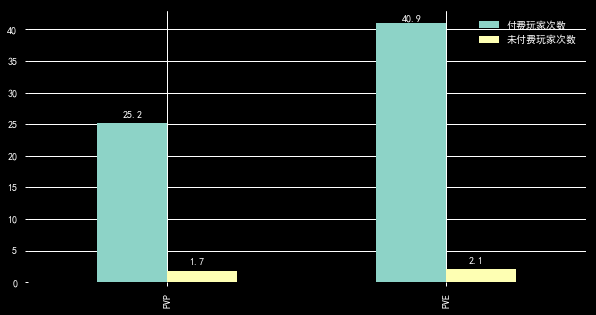

In [25]:
# # 多系列柱状图
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background') 
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
pv_count=[[25.193803,1.723228],[40.949540,2.141877]]
pk1=pd.DataFrame(pv_count,index=['PVP','PVE'],columns=['付费玩家次数','未付费玩家次数'])
a=pk1.plot(kind='bar',figsize=(10,5))
a.text(-0.16,26,'25.2')
a.text(0.08,2.8,'1.7')
a.text(0.84,41.3,'40.9')
a.text(1.08,3,'2.1');

可以得出：

- 付费玩家的PVP和PVE次数明显高于未付费玩家，近20倍。玩家PVE次数比PVP次数较高


7.2 分析玩家的PVP和PVE概率

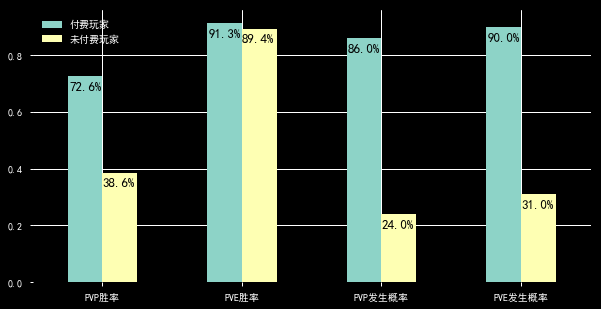

In [26]:
plt.rcParams.update({'font.size': 13})
pv=[[0.726,0.386],[0.913,0.894],[0.86,0.24],[0.90,0.31]]
pk=pd.DataFrame(pv,index=['PVP胜率','PVE胜率','PVP发生概率','PVE发生概率'],columns=['付费玩家','未付费玩家'])
a=pk.plot(kind='bar',figsize=(10,5),rot=0)
x = np.arange(4)
y1=pk['付费玩家'].tolist()
y2=pk['未付费玩家'].tolist()
for i,j in zip(x,y1):
    a.text(-0.24+i,j-0.05,str(j*100) + '%',color='black') 
for i,j in zip(x,y2):
    a.text(i,j-0.05,str(j*100) + '%',color='black')

由以上得出：

- 游戏玩家都更倾向于发起PVE模式，PVE难度低于PVP模式，从获胜率来看，原因是PVE模式中获胜的概率远高于PVP；
- 在PVP模式中，付费玩家的发起概率和获胜概率都高于普通用户，可见付费玩家更喜欢挑战难度较高，不确定性因素较多的玩家对玩家的模式

7.4 游戏付费道具使用情况

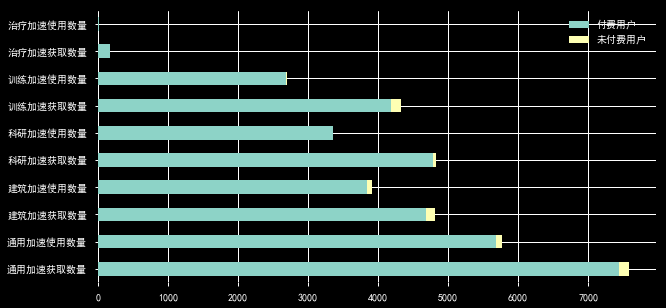

In [27]:
#加速道具分析
#付费用户
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
data_pay7_accelerat=datac_pay7[['general_acceleration_add_value','general_acceleration_reduce_value','building_acceleration_add_value',
            'building_acceleration_reduce_value','reaserch_acceleration_add_value',
            'reaserch_acceleration_reduce_value','training_acceleration_add_value',
            'training_acceleration_reduce_value','treatment_acceleraion_add_value',
            'treatment_acceleration_reduce_value']].mean()
#未付费用户
data_npay7_accelerat=datac_npay7[['general_acceleration_add_value','general_acceleration_reduce_value','building_acceleration_add_value',
            'building_acceleration_reduce_value','reaserch_acceleration_add_value',
            'reaserch_acceleration_reduce_value','training_acceleration_add_value',
            'training_acceleration_reduce_value','treatment_acceleraion_add_value',
            'treatment_acceleration_reduce_value']].mean()
data_resource=pd.concat([data_pay7_accelerat,data_npay7_accelerat],axis=1)
data_resource.columns=['付费用户','未付费用户']
data_resource.index=['通用加速获取数量', '通用加速使用数量', '建筑加速获取数量', '建筑加速使用数量', '科研加速获取数量', '科研加速使用数量', '训练加速获取数量', '训练加速使用数量', '治疗加速获取数量', '治疗加速使用数量']
data_resource.plot.barh(figsize=(10,5),rot=0,stacked=True)

由此得出：

- 付费玩家各项加速数量明显高于未付费玩家
- 其中通用加速的获取和使用数量最高，治疗加速获取和使用最少，相对其它参数不是一个数量级

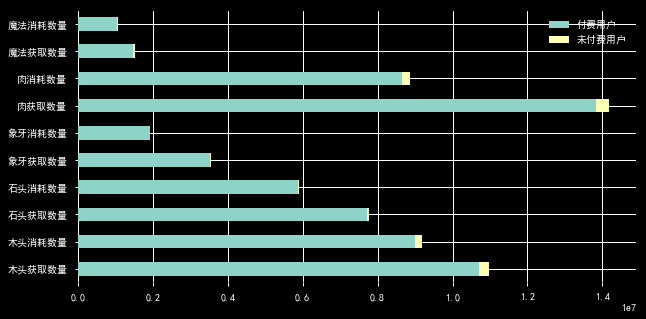

In [28]:
data_pay_resource=datac_pay7[['wood_add_value','wood_reduce_value','stone_add_value','stone_reduce_value',
                              'ivory_add_value','ivory_reduce_value','meat_add_value','meat_reduce_value',
                              'magic_add_value','magic_reduce_value']].mean()

data_npay_resource=datac_npay7[['wood_add_value','wood_reduce_value','stone_add_value','stone_reduce_value',
                              'ivory_add_value','ivory_reduce_value','meat_add_value','meat_reduce_value',
                              'magic_add_value','magic_reduce_value']].mean()

data_resource=pd.concat([data_pay_resource,data_npay_resource],axis=1)
data_resource.columns=['付费用户','未付费用户']
data_resource.index=['木头获取数量','木头消耗数量','石头获取数量','石头消耗数量','象牙获取数量','象牙消耗数量',
                       '肉获取数量','肉消耗数量','魔法获取数量','魔法消耗数量']
data_resource.plot.barh(figsize=(10,5),rot=0,stacked=True)

由此得出：

- 付费玩家各项材料数量明显高于未付费玩家
- 材料中肉消耗数量和获取数量最多，其次是木头和石头，而魔法和象牙最少


7、 研究评估标准

评分标准是RMSE，均方根误差

如果有一个土豪客户是付费15000，但是模型只猜测是付费1000，那么(15000-1000)^2/828934=236，开根号得到15.38，一个土豪客户的误判，就可以令评分标准飙升。
如果客户是给0.99的，但是预判了1.99，那么(1.99-0.99)^2=1，开根号也是1，如果每个客户都误判1元，RMSE也就+1。

**成败看土豪？？？**


# 小结

1.这是一次运营准备不充分的活动

2.需要调整用户获取渠道

理由如下：

- 2.19、2.20分别有两次注册高峰，活动开始时，新用户注册数量相对平时增加了2倍左右，但是活动当天没有带来更多的付费用户
- 活动过后，付费率也在持续下降，活动后付费率及活跃率虽然恢复平稳，但和活动前相比，变化不明显。
- 付费率小幅提升都是在活动之后的1-2天
- 较低的ARPU，45天内，用户平均付费为1.79元（一般ARPU在3~5元）

建议:

- 提升运营活动本身的设计，重点关注有效的用户获取渠道，同时优化活动宣传渠道和广告目标受众，精准投放
- 深入分析付费用户的用户画像，提高用户画像的有效性和精准性
- 活动带来大量的新用户的同时，提高用户留存率，同时挖掘留存用户的潜力。
- 优化游戏的平衡性和设计，提高大部分未付费的用户体验感。

玩家行为可作为提高游戏收入的参考：

- 玩家总体倾向于PVE模式，且PVE模式胜率较高。但付费玩家的相比普通玩家更喜欢PVP模式，并且胜率也远高于普通玩家
- 付费玩家在加速类资源的使用率均高于普通玩家，其中通用加速类最多，而治疗加速类最少。
- 在游戏资源上，付费玩家各项材料数量明显高于未付费玩家，材料中肉类的数量最多，其他差别不大，但魔法和象牙最少。

由于时间关系EDA做得不够详细，正常情况还得按照思维导图框架画更多图表观察数据，上面的结论也只是一个初步的现象，并不是一个根本的原因，更加不能说明那个变量是影响用户付费的最大因素，也不清楚变量的变化是怎么影响用户付费的，下面会使用模型解释算法进行寻找变量的关系。

# 由EDA后思考的特征工程思路（初步想法）
- 1.正常使用那么干净的数据集直接进行建模是不可能得到很好的排名，大家都会使用各种算法尝试一遍的，所以必须增加新的特征或者分部预测
- 2.由EDA观察到付费的金额方差极大，一个人45天花费3.8万块也有，大部分人都不花钱，按照比赛方的评估标准，只要预测错了一个土豪就会大大增大均方根误差
- 3.所以该数据集适合做分类，我能不能先建立分类模型，把测试集用户45天不会付费预测出来，再把会付费用户拿出来进行回归模型的建立。

所以，接下来建模会使用前7天付费的数据，分两步，先分类出谁会继续付款，然后回归分析继续给钱的玩家会付款多少？还有第三部分，就是忽略掉前7天没付款，但是后面45天会付款的

# 特征工程

In [29]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler,MinMaxScaler
pre_data=pd.read_csv(r'data/data_pre.csv')
test_data=pd.read_csv(r'data/tap_fun_test.csv')
train_data=pd.read_csv(r'data/tap_fun_train.csv')
import datetime
import numpy
# 国内公测时间 2017年8月13日
# 增加 test_data 的 注册日期距离公测时间的天数
def add_time_dif(array):
    new_array = numpy.zeros(shape=(array.shape[0],1))
    for i in np.arange(array['register_time'].shape[0]):
        the_array = array['register_time']
        sd = datetime.datetime.strptime('2017-08-13 00:00:00', '%Y-%m-%d %H:%M:%S')
        d = datetime.datetime.strptime(the_array[i], '%Y-%m-%d %H:%M:%S')
        time = (d - sd).days + 1
        new_array[i] = int(time)    
    array['time_dif'] = new_array
    #修改为int16 减少计算量
    array['time_dif'] = numpy.int16(array['time_dif'])
    return array
test_data = add_time_dif(test_data)
# 增加 train_data 的 注册日期距离公测时间的天数
def my_none():
    new_array = numpy.zeros(shape=(train_data.shape[0],1))
    array = np.array(train_data['register_time']).reshape(len(train_data['register_time']),1)
    for i in np.arange(train_data['register_time'].shape[0]):
        sd = datetime.datetime.strptime('2017-08-13 00:00:00', '%Y-%m-%d %H:%M:%S')
        d = datetime.datetime.strptime(array[i,0], '%Y-%m-%d %H:%M:%S')
        time = (d - sd).days + 1
        new_array[i] = int(time)    
    train_data['time_dif'] = new_array
    # #修改为int16 减少计算量
    train_data['time_dif'] = numpy.int16(train_data['time_dif'])
my_none()
train_data.drop_duplicates(keep='first', inplace=True)
del train_data['register_time'],test_data['register_time']
pre_data.drop_duplicates(keep='first', inplace=True)
#7天内有付费的用户
train_data=train_data[train_data['pay_price']>0]
test_data_prect=test_data[test_data['pay_price']>0]
#7天内没有付费的用户
test_data_rule=test_data[test_data['pay_price']==0]
def rate_feat(df):
    for i in pre_data['wood']:
        df[str(i)+'rate']=df[str(i)+'_reduce_value']/df[str(i)+'_add_value']        
    df['pvp_rate']=df['pvp_lanch_count']/df['pvp_battle_count']
    df['pvp_win_rate']=df['pvp_win_count']/df['pvp_battle_count']
    df['pay_count_rate']=df['pay_count']/df['avg_online_minutes']
    df['pay_mean']=df['pay_price']/df['pay_count']
    df['pve_win_rate']=df['pve_win_count']/df['pve_battle_count']
    df['battle_count']=df['pve_battle_count']+df['pvp_battle_count']
    df['pvp_battle_rate']=df['pve_battle_count']/df['battle_count']
    df['win_rate']=(df['pve_win_count']+df['pvp_win_count'])/df['pvp_battle_rate']
    df['pve_rate']=df['pve_lanch_count']/df['pve_battle_count']
    df['lanch_count']=df['pvp_lanch_count']+df['pve_lanch_count']
    df['lanch_rate']=df['pvp_lanch_count']/df['lanch_count']
    df['battle_rate']=df['pvp_battle_count']/df['pve_battle_count']
    df['lauch_battle_rate']=df['pvp_lanch_count']/df['pve_lanch_count']
    df['treat_rate']=df['treatment_acceleration_reduce_value']/df['treatment_acceleraion_add_value']
    df['shaman_battle_rate']=df['shaman_reduce_value']/df['battle_count']    
    df['cavalry_battle_rate']=df['cavalry_reduce_value']/df['battle_count']
    df['infantry_battle_rate']=df['infantry_reduce_value']/df['battle_count']
    df['pvp_passive_rate']=(df['pvp_battle_count']-df['pve_lanch_count'])/df['time_dif']
    df['wound_left_rate']=(df['wound_cavalry_reduce_value']+df['wound_infantry_reduce_value']+df['wound_shaman_reduce_value'])/df['treatment_acceleration_reduce_value']
    return df
df=rate_feat(test_data_prect)
df1=rate_feat(train_data)
test_feat=pd.concat([df,test_data_prect],axis=1)
train_feat=pd.concat([df1,train_data],axis=1)
test_feat=test_feat.T.drop_duplicates().T
train_feat=train_feat.T.drop_duplicates().T
print('clear_over')
print('test feat over')
print('train feat over')
drop = ['user_id','pay_price']
train_feat['label']=train_feat['prediction_pay_price']
train_idx=train_data[drop]
test_idx=test_data_prect[drop]
test_idx_rule=test_data_rule[drop]
y = train_feat.pop('label')
del train_feat['prediction_pay_price']
data_feat=pd.concat([train_feat, test_feat])
data_feat=data_feat.drop(drop, axis=1)
y=y.replace(np.NaN,0)
train_feat=data_feat[:len(y)]
test_feat=data_feat[len(y):]

clear_over
test feat over
train feat over


# 模型训练

In [30]:
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
lgb_train = lgb.Dataset(train_feat, y)
print('开始训练......')
params = {
            'boosting_type': 'gbdt',
            'metric': {'l2',}, 
            'learning_rate' : 0.01, 
             'verbose': 0,
            'objective': 'regression', 
            'seed': 1024,
            'nthread': 12,
}
gbm = lgb.train(params,lgb_train,num_boost_round=170)
gbm.save_model('gbm.model')
y_prob = gbm.predict(test_feat)
test_idx['label'] = y_prob
test_idx_rule['prediction_pay_price']=0
res = pd.concat([test_idx, test_idx_rule])
#res[['user_id','prediction_pay_price']].to_csv("new_add_dif_time.csv", sep=',',index=False)

开始训练......


# 解释模型

- 最后金额预测使用2个模型进行预测的，由于时间问题，所以这里只拿第二个回归模型进行解释（用户前7天内付费后45天内会付费多少钱的回归模型）

### 特征重要性排行

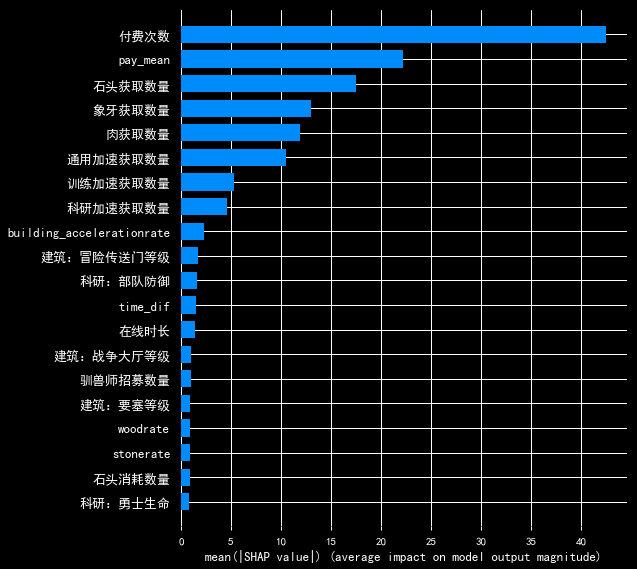

In [31]:
import shap
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
jieshi=pd.read_excel(r'data/tap4fun 数据字段解释.xlsx')
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(train_feat)
shap.summary_plot(shap_values, train_feat, plot_type="bar",axis_color='#ffffff',feature_names=jieshi['中文'].tolist())

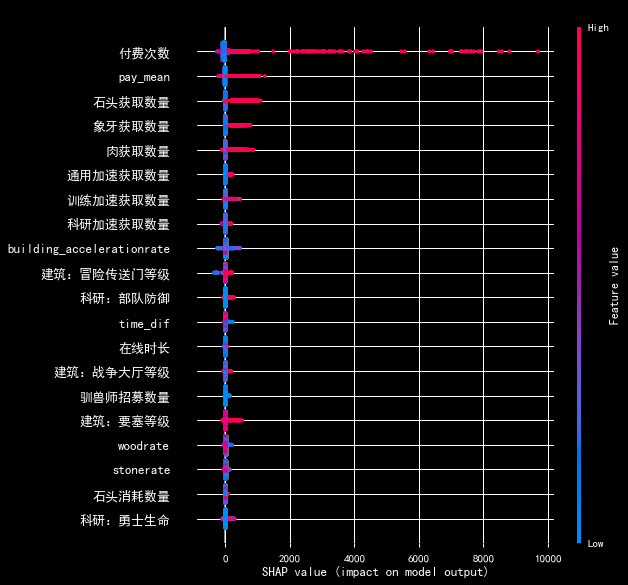

In [32]:
shap.summary_plot(shap_values, train_feat,axis_color='#ffffff',feature_names=jieshi['中文'].tolist())

#### 单变量依存度

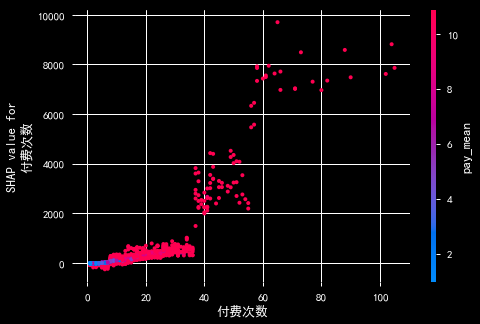

In [33]:
shap.dependence_plot("付费次数",shap_values, train_feat,axis_color='#ffffff',feature_names=jieshi['中文'].tolist())

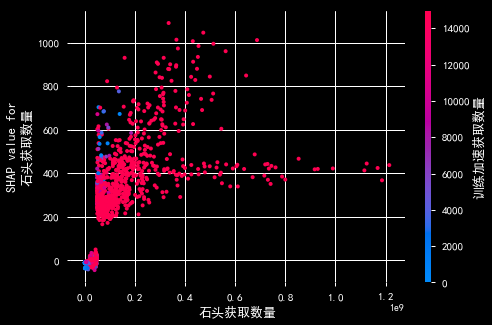

In [34]:
shap.dependence_plot("石头获取数量",shap_values, train_feat,axis_color='#ffffff',feature_names=jieshi['中文'].tolist())

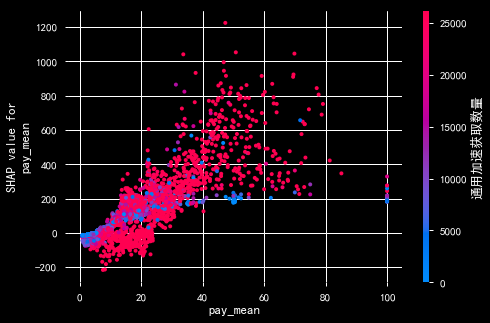

In [35]:
shap.dependence_plot("pay_mean",shap_values, train_feat,axis_color='#ffffff',feature_names=jieshi['中文'].tolist())

#### 双变量依存度

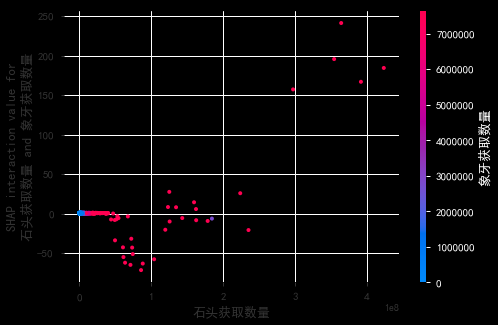

In [36]:
import shap
shap_interaction_values = shap.TreeExplainer(gbm).shap_interaction_values(train_feat.iloc[:2000,:])
shap.dependence_plot(
    ("石头获取数量", "象牙获取数量"),
    shap_interaction_values, train_feat.iloc[:2000,:],
    feature_names=jieshi['中文'].tolist()
)

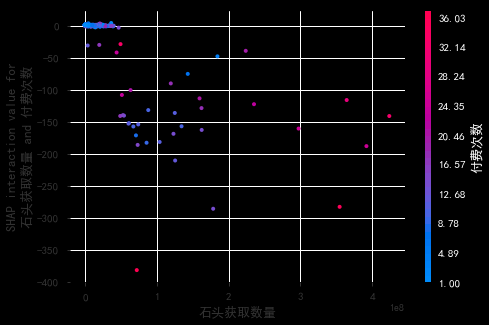

In [37]:
shap.dependence_plot(
    ("石头获取数量", "付费次数"),
    shap_interaction_values, train_feat.iloc[:2000,:],
    axis_color='#ffffff',
    feature_names=jieshi['中文'].tolist(),
   
)

#### 单样本力量图

In [38]:
import shap
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(train_feat)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], train_feat.iloc[0,:])

In [39]:
shap.force_plot(explainer.expected_value, shap_values[1,:], train_feat.iloc[1,:])

In [40]:
shap.force_plot(explainer.expected_value, shap_values[100,:], train_feat.iloc[100,:])